In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [3]:
# 导入数据
train_data = pd.read_csv('./data/data119778/train.csv', index_col= 'id')
testA_data = pd.read_csv('./data/data119778/testA.csv', index_col= 'id')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 0 to 799999
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   loanAmnt            800000 non-null  float64
 1   term                800000 non-null  int64  
 2   interestRate        800000 non-null  float64
 3   installment         800000 non-null  float64
 4   grade               800000 non-null  object 
 5   subGrade            800000 non-null  object 
 6   employmentTitle     799999 non-null  float64
 7   employmentLength    753201 non-null  object 
 8   homeOwnership       800000 non-null  int64  
 9   annualIncome        800000 non-null  float64
 10  verificationStatus  800000 non-null  int64  
 11  issueDate           800000 non-null  object 
 12  isDefault           800000 non-null  int64  
 13  purpose             800000 non-null  int64  
 14  postCode            799999 non-null  float64
 15  regionCode          800000 non-nul

In [ ]:
# train[train['isDefault'] == 1][['employmentLength']].describe()

In [ ]:
train = train_data.copy()
testA = testA_data.copy()

## 数据探索

### 查看数据

In [ ]:
# train.info()

In [ ]:
# train.describe(percentiles=[0.4, 0.6, 0.8, 0.9]).T

In [ ]:
train.head(5).transpose()

id,0,1,2,3,4
loanAmnt,35000,18000,12000,11000,3000
term,5,5,5,3,3
interestRate,19.52,18.49,16.99,7.26,12.99
installment,917.97,461.9,298.17,340.96,101.07
grade,E,D,D,A,C
subGrade,E2,D2,D3,A4,C2
employmentTitle,320,219843,31698,46854,54
employmentLength,2 years,5 years,8 years,10+ years,NaN
homeOwnership,2,0,0,1,1
annualIncome,110000,46000,74000,118000,29000


### 检查共同特征

In [ ]:
common_columns = []
for column in train.columns:
    if column in testA.columns:
        common_columns.append(column)

In [ ]:
len(common_columns), len(train.columns), len(testA.columns)

(45, 46, 45)

### 列出object 类型特征

In [ ]:
train.select_dtypes(include='O')
# testA.select_dtypes(include='O')

,grade,subGrade,employmentLength,issueDate,earliesCreditLine
id,,,,,
0,E,E2,2 years,2014-07-01,Aug-2001
1,D,D2,5 years,2012-08-01,May-2002
2,D,D3,8 years,2015-10-01,May-2006
3,A,A4,10+ years,2015-08-01,May-1999
4,C,C2,NaN,2016-03-01,Aug-1977
...,...,...,...,...,...
799995,C,C4,7 years,2016-07-01,Aug-2011
799996,A,A4,10+ years,2013-04-01,May-1989
799997,C,C3,10+ years,2015-10-01,Jul-2002


### 检查数字特征的连续性

In [ ]:
train.select_dtypes(exclude='O').columns

Index(['loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle',
       'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0',
       'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11',
       'n12', 'n13', 'n14'],
      dtype='object')

In [ ]:
# train['n1'].unique()

In [ ]:
numerical_series_fea=[]
numerical_noseries_fea=[]

for fea in train.select_dtypes(exclude='O').columns:
    numerical_series_fea.append(fea) if train[fea].unique().size >= 10 else numerical_noseries_fea.append(fea)

In [ ]:
numerical_series_fea,numerical_noseries_fea

(['loanAmnt',
  'interestRate',
  'installment',
  'employmentTitle',
  'annualIncome',
  'purpose',
  'postCode',
  'regionCode',
  'dti',
  'delinquency_2years',
  'ficoRangeLow',
  'ficoRangeHigh',
  'openAcc',
  'pubRec',
  'pubRecBankruptcies',
  'revolBal',
  'revolUtil',
  'totalAcc',
  'title',
  'n0',
  'n1',
  'n2',
  'n3',
  'n4',
  'n5',
  'n6',
  'n7',
  'n8',
  'n9',
  'n10',
  'n13',
  'n14'],
 ['term',
  'homeOwnership',
  'verificationStatus',
  'isDefault',
  'initialListStatus',
  'applicationType',
  'policyCode',
  'n11',
  'n12'])

In [ ]:
testA_numerical_series_fea=[]
testA_numerical_noseries_fea=[]

for fea in testA.select_dtypes(exclude='O').columns:
    testA_numerical_series_fea.append(fea) if testA[fea].unique().size >= 10 else testA_numerical_noseries_fea.append(fea)

In [ ]:
testA_numerical_series_fea, testA_numerical_noseries_fea

(['loanAmnt',
  'interestRate',
  'installment',
  'employmentTitle',
  'annualIncome',
  'purpose',
  'postCode',
  'regionCode',
  'dti',
  'delinquency_2years',
  'ficoRangeLow',
  'ficoRangeHigh',
  'openAcc',
  'pubRec',
  'pubRecBankruptcies',
  'revolBal',
  'revolUtil',
  'totalAcc',
  'title',
  'n0',
  'n1',
  'n2',
  'n3',
  'n4',
  'n5',
  'n6',
  'n7',
  'n8',
  'n9',
  'n10',
  'n13',
  'n14'],
 ['term',
  'homeOwnership',
  'verificationStatus',
  'initialListStatus',
  'applicationType',
  'policyCode',
  'n11',
  'n12'])

### 检查空值

In [ ]:
include_nan_fea = []

for fea in train.columns:
    percent_of_null = train[fea].isnull().sum()/train.shape[0] * 100
    if percent_of_null > 0 :
        include_nan_fea.append((fea, percent_of_null))

In [ ]:
include_nan_fea

[('employmentTitle', 0.000125),
 ('employmentLength', 5.849875),
 ('postCode', 0.000125),
 ('dti', 0.029875000000000002),
 ('pubRecBankruptcies', 0.050624999999999996),
 ('revolUtil', 0.06637499999999999),
 ('title', 0.000125),
 ('n0', 5.03375),
 ('n1', 5.03375),
 ('n2', 5.03375),
 ('n3', 5.03375),
 ('n4', 4.1548750000000005),
 ('n5', 5.03375),
 ('n6', 5.03375),
 ('n7', 5.03375),
 ('n8', 5.033875),
 ('n9', 5.03375),
 ('n10', 4.1548750000000005),
 ('n11', 8.719000000000001),
 ('n12', 5.03375),
 ('n13', 5.03375),
 ('n14', 5.03375)]

In [ ]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:23]


,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
42,n11,5,8.719000,91.210250,float64
7,employmentLength,11,5.849875,32.844125,object
39,n8,102,5.033875,5.601000,float64
45,n14,31,5.033750,23.437625,float64
34,n3,50,5.033750,14.651375,float64
44,n13,28,5.033750,89.516375,float64
43,n12,5,5.033750,94.664375,float64
31,n0,39,5.033750,72.428375,float64
32,n1,33,5.033750,20.376000,float64
40,n9,44,5.033750,14.766750,float64


In [ ]:
testA_include_nan_fea = []

for fea in testA.columns:
    percent_of_null = testA[fea].isnull().sum()/testA.shape[0] * 100
    if percent_of_null > 0 :
        testA_include_nan_fea.append((fea, percent_of_null))

In [ ]:
testA_include_nan_fea

[('dti', 0.0305),
 ('employmentLength', 5.8709999999999996),
 ('n0', 5.0555),
 ('n1', 5.0555),
 ('n10', 4.197),
 ('n11', 8.7875),
 ('n12', 5.0555),
 ('n13', 5.0555),
 ('n14', 5.0555),
 ('n2', 5.0555),
 ('n3', 5.0555),
 ('n4', 4.197),
 ('n5', 5.0555),
 ('n6', 5.0555),
 ('n7', 5.0555),
 ('n8', 5.0555),
 ('n9', 5.0555),
 ('pubRecBankruptcies', 0.058),
 ('revolUtil', 0.0635)]

### 检查分布一致性、异常值

In [ ]:
# train['Source'] = 'Train'
# testA['Source'] = 'Test'

In [ ]:
merge_data = pd.concat((train.join(pd.DataFrame(['Train' for i in range(len(train))], index=train.index, columns=['Source']), how='left'),
                        testA.join(pd.DataFrame(['Test' for i in range(len(testA))], index=testA.index, columns=['Source']), how='left')))

In [ ]:
df_melted = pd.melt(merge_data, id_vars= ['Source'],
                    # value_vars=testA_numerical_series_fea
                    )

In [ ]:
df_melted

,Source,variable,value
0,Train,loanAmnt,35000
1,Train,loanAmnt,18000
2,Train,loanAmnt,12000
3,Train,loanAmnt,11000
4,Train,loanAmnt,3000
...,...,...,...
45999995,Test,n14,4
45999996,Test,n14,0
45999997,Test,n14,0
45999998,Test,n14,2


In [ ]:
#画出各特征的分布图

g = sns.FacetGrid(df_melted, hue = 'Source', col='variable', col_wrap= 2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.add_legend()

### 检查特征取值范围、异常值

In [ ]:
df_col_val = pd.DataFrame()
for col in merge_data.columns:
    col_val_cnt = merge_data[col].value_counts()
    df_col_val = df_col_val.append(pd.DataFrame({'fea_name': col, 'value':list(col_val_cnt.index), 'cnts':col_val_cnt.values}))

In [ ]:
df_col_val

In [ ]:
df_col_val.to_csv('./work/features/df_col_val.csv', index = None)

异常值：
1、训练集有两条记录 dti = -1：merge_data[merge_data['dti'] == -1].T；

In [ ]:
# merge_data[merge_data['dti']== -1].T
merge_data[['loanAmnt', 'annualIncome', 'dti']].join(pd.DataFrame(merge_data['loanAmnt']/merge_data['annualIncome']), how='left')[merge_data['dti']== -1]
# merge_data['loanAmnt']/merge_data['annualIncome']

,loanAmnt,annualIncome,dti,0
id,,,,
258110,17000.0,75000.0,-1.0,0.226667
356894,15000.0,94000.0,-1.0,0.159574


## 特征工程

### 处理异常值

In [ ]:
#处理dti = -1 的异常数据
mean_dti = train[np.array(train['dti'] >= 0) * np.array(train['isDefault'] == 0)]['dti'].mean()

In [ ]:
train.loc[train['dti'] < 0, 'dti'] = mean_dti

In [ ]:
train.iloc[[258110, 356894]]['dti']

id
258110    17.811673
356894    17.811673
Name: dti, dtype: float64

### 填充空值

In [ ]:
# train[testA_numerical_series_fea]
# train[['regionCode']].mode()

#### 处理连续性特征的空值

In [3]:
categorical_fea = {'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', 'initialListStatus', 'applicationType', 'policyCode', 'title'}

In [ ]:
numerical_fea = set(train.select_dtypes(exclude=['object']).columns)

In [ ]:
numerical_fea = list(numerical_fea - categorical_fea - {'isDefault'})

In [ ]:
train[numerical_fea] = train[numerical_fea].fillna(train[numerical_fea].median())
testA[numerical_fea] = testA[numerical_fea].fillna(testA[numerical_fea].median())

#### 处理分类特征的空值

In [ ]:
train.select_dtypes(include=['object']).columns

Index(['grade', 'subGrade', 'employmentLength', 'issueDate',
       'earliesCreditLine'],
      dtype='object')

In [ ]:
list(set(train.select_dtypes(include=['object']).columns).union(categorical_fea))

['issueDate',
 'earliesCreditLine',
 'employmentLength',
 'title',
 'policyCode',
 'verificationStatus',
 'initialListStatus',
 'employmentTitle',
 'grade',
 'regionCode',
 'postCode',
 'purpose',
 'homeOwnership',
 'subGrade',
 'applicationType']

In [ ]:
train[list(set(train.select_dtypes(include=['object']).columns).union(categorical_fea))].isnull().sum(axis = 0)

purpose                   0
applicationType           0
earliesCreditLine         0
employmentTitle           1
regionCode                0
homeOwnership             0
employmentLength      46799
initialListStatus         0
subGrade                  0
grade                     0
policyCode                0
title                     1
verificationStatus        0
postCode                  1
issueDate                 0
dtype: int64

##### 处理employmentLength 的空值

In [4]:
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder

In [ ]:
#测试随机森林拟合缺失值的效果，效果不理想

def test_missing(df,estimate_list,miss_col):
    """df要处理的数据帧，estimate_list用来估计缺失值的字段列表,miss_col缺失字段名称;会直接在原来的数据帧上修改"""
    df = df.copy()
    col_list=estimate_list
    col_list.append(miss_col)   
    process_df = df.loc[:,col_list]

    object_cols = list(process_df.select_dtypes(include='O').columns)
    object_cols.remove(miss_col)

    class_le= LabelEncoder()
    for i in object_cols:
        process_df.loc[:,i]=class_le.fit_transform(process_df.loc[:,i])
        # process_df.loc[:,i]=process_df.loc[:,i].astype(int)
    # 分成已知该特征和未知该特征两部分
    known=process_df[process_df[miss_col].notnull()]
    known.iloc[:, -1]=class_le.fit_transform(known.iloc[:, -1])
    # unknown = process_df[process_df[miss_col].isnull()].values
    # X为特征属性值
    X = known.iloc[:, :-1]

    # y为结果标签值
    y = known.iloc[:, -1:-2:-1]

    X = X.fillna(X.mean())

    X_train,X_eval,y_train,y_eval = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

    # fit到RandomForestRegressor之中
    rfr = ensemble.RandomForestRegressor(random_state=1, n_estimators=20,max_depth=4,n_jobs=-1)
    rfr.fit(X_train, y_train)
    # 用得到的模型进行验证
    y_pred = rfr.predict(X_eval)#.round(0).astype(int)

    # for_class_pred = y_pred.astype(int)
    # for_class_real = y_eval.astype(int)

    # print(accuracy_score(for_class_real, for_class_pred))


    # print('y_pred:',type(y_pred))
    # print('y_pred:',y_pred.shape)

    return y_pred, y_eval


In [ ]:
#测试lgbm拟合缺失值的效果，测试结果比randomForest好

def set_missing(df,estimate_list,miss_col):
    """df要处理的数据帧，estimate_list用来估计缺失值的字段列表,miss_col缺失字段名称;会直接在原来的数据帧上修改"""
    df = df.copy()
    col_list=estimate_list
    col_list.append(miss_col)   
    process_df = df.loc[:,col_list]

    object_cols = list(process_df.select_dtypes(include='O').columns)
    object_cols.remove(miss_col)

    class_le= LabelEncoder()
    for i in object_cols:
        process_df.loc[:,i]=class_le.fit_transform(process_df.loc[:,i])
        # process_df.loc[:,i]=process_df.loc[:,i].astype(int)
    # 分成已知该特征和未知该特征两部分
    known = process_df[process_df[miss_col].notnull()]
    known.iloc[:, -1] = class_le.fit_transform(known.iloc[:, -1])

    #需要填充的数据：
    unknown = process_df[process_df[miss_col].isnull()]
    
    # X为特征属性值
    X = known.iloc[:, :-1]

    # y为结果标签值
    y = known.iloc[:, -1:-2:-1]

    X_train,X_eval,y_train,y_eval = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

    # fit到LGBMClassifier之中
    clf_ex = lgb.LGBMClassifier(objective='multiclass', metric = 'multi_logloss,auc_mu', 
                                n_estimators=500, 
                                max_depth=5, learning_rate=0.1)

    clf_ex.fit(X_train, y_train, eval_set=(X_eval, y_eval),
               early_stopping_rounds = 10)

    # # 用得到的模型进行验证
    # y_pred = clf_ex.predict(X_eval)#.round(0).astype(int)

    # return y_pred, y_eval

    # 用得到的模型进行未知特征值预测
    predicted = clf_ex.predict(unknown.iloc[:, :-1])#.round(0).astype(int)
    predicted = class_le.inverse_transform(predicted)

    # 用得到的预测结果填补原缺失数据
    df.loc[(df[miss_col].isnull()), miss_col] = predicted
    return df


In [ ]:
estimate_list = list(train.columns)
estimate_list.remove('employmentLength')
miss_col = 'employmentLength'

In [ ]:
#测试模型
# y_pred, y_eval = test_missing(train, estimate_list, miss_col)

In [ ]:
# #检查测试结果
# acc_score=accuracy_score(y_eval, y_pred.round())
# mse_err=mean_squared_error(y_eval, y_pred.round())
# recall=recall_score(y_eval, y_pred.round(), average='micro')
# acc_score, mse_err, recall

In [ ]:
#获取预测的缺失值
train = set_missing(train, estimate_list, miss_col)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's multi_logloss: 2.1101	valid_0's auc_mu: 0.586909
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 2.10192	valid_0's auc_mu: 0.589626
[3]	valid_0's multi_logloss: 2.09546	valid_0's auc_mu: 0.591519
[4]	valid_0's multi_logloss: 2.09012	valid_0's auc_mu: 0.592826
[5]	valid_0's multi_logloss: 2.08572	valid_0's auc_mu: 0.594113
[6]	valid_0's multi_logloss: 2.082	valid_0's auc_mu: 0.595448
[7]	valid_0's multi_logloss: 2.07888	valid_0's auc_mu: 0.59633
[8]	valid_0's multi_logloss: 2.07624	valid_0's auc_mu: 0.597001
[9]	valid_0's multi_logloss: 2.07393	valid_0's auc_mu: 0.597714
[10]	valid_0's multi_logloss: 2.07185	valid_0's auc_mu: 0.598573
[11]	valid_0's multi_logloss: 2.07007	valid_0's auc_mu: 0.598966
[12]	valid_0's multi_logloss: 2.06831	valid_0's auc_mu: 0.599689
[13]	valid_0's multi_logloss: 2.06683	vali

In [ ]:
estimate_list = list(testA.columns)
estimate_list.remove('employmentLength')
miss_col = 'employmentLength'
testA = set_missing(testA, estimate_list, miss_col)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's multi_logloss: 2.10912	valid_0's auc_mu: 0.582548
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 2.10081	valid_0's auc_mu: 0.58661
[3]	valid_0's multi_logloss: 2.09433	valid_0's auc_mu: 0.58809
[4]	valid_0's multi_logloss: 2.08885	valid_0's auc_mu: 0.591025
[5]	valid_0's multi_logloss: 2.0844	valid_0's auc_mu: 0.592465
[6]	valid_0's multi_logloss: 2.08081	valid_0's auc_mu: 0.593494
[7]	valid_0's multi_logloss: 2.07771	valid_0's auc_mu: 0.594067
[8]	valid_0's multi_logloss: 2.0751	valid_0's auc_mu: 0.594438
[9]	valid_0's multi_logloss: 2.07291	valid_0's auc_mu: 0.594954
[10]	valid_0's multi_logloss: 2.07095	valid_0's auc_mu: 0.5957
[11]	valid_0's multi_logloss: 2.069	valid_0's auc_mu: 0.596424
[12]	valid_0's multi_logloss: 2.06744	valid_0's auc_mu: 0.597314
[13]	valid_0's multi_logloss: 2.06613	valid_0'

In [5]:
categorical_fea = list(categorical_fea)

In [ ]:
#方法1 使用众数补充空值，众数可能返回多个
train[categorical_fea] = train[categorical_fea].fillna(train[categorical_fea].mode()[0])
testA[categorical_fea] = testA[categorical_fea].fillna(testA[categorical_fea].mode()[0])

### 标签编码

In [ ]:
#标签编码 grade、subGrade

# merge_data['grade'].unique(), 
np.sort(merge_data['subGrade'].unique())

array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5'], dtype=object)

In [ ]:
grade_map = dict(zip(('A', 'B', 'C', 'D', 'E', 'F', 'G'), (0, 5, 10, 15, 20, 25, 30, 35)))
subGrade_map =dict(zip(('A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2','E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'),
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34)))

In [ ]:
train['grade'] = train['grade'].map(grade_map)
testA['grade'] = testA['grade'].map(grade_map)

train['subGrade'] = train['subGrade'].map(subGrade_map)
testA['subGrade'] = testA['subGrade'].map(subGrade_map)

In [ ]:
# 标签编码 employmentLength

merge_data['employmentLength'].unique()


array(['2 years', '5 years', '8 years', '10+ years', nan, '7 years',
       '9 years', '1 year', '3 years', '< 1 year', '4 years', '6 years'],
      dtype=object)

In [ ]:
employmentLength_map = dict(zip(( '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'),
(0 , 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)))

In [ ]:
train['employmentLength'] = train['employmentLength'].map(employmentLength_map)
testA['employmentLength'] = testA['employmentLength'].map(employmentLength_map)

In [ ]:
#标签编码 issueDate	

merge_data['issueDate'].min()

'2007-06-01'

In [ ]:
train['issueDate'] = pd.to_datetime(train['issueDate'])
testA['issueDate'] = pd.to_datetime(testA['issueDate'])

In [ ]:
train['issueDate_year'] = pd.to_datetime(train['issueDate']).dt.year
train['issueDate_month'] = pd.to_datetime(train['issueDate']).dt.month

testA['issueDate_year'] = pd.to_datetime(testA['issueDate']).dt.year
testA['issueDate_month'] = pd.to_datetime(testA['issueDate']).dt.month

In [ ]:
base_time = pd.datetime.strptime('2007-06-01', '%Y-%m-%d')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
train['issueDate_diff'] = train['issueDate'].apply(lambda x: (x - base_time).days)
testA['issueDate_diff'] = testA['issueDate'].apply(lambda x: (x - base_time).days)

In [ ]:
train.drop(columns='issueDate', inplace = True)
testA.drop(columns='issueDate', inplace = True)

In [ ]:
# 标签编码 earliesCreditLine
pd.to_datetime(merge_data['earliesCreditLine']).min()

Timestamp('1944-01-01 00:00:00')

In [ ]:
base_time2 = pd.datetime.strptime('1944-01-01', '%Y-%m-%d')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
train['earliesCreditLine'] = pd.to_datetime(train['earliesCreditLine'])
testA['earliesCreditLine'] = pd.to_datetime(testA['earliesCreditLine'])

In [ ]:
train['earliesCreditLine_year'] = pd.to_datetime(train['earliesCreditLine']).dt.year
train['earliesCreditLine_month'] = pd.to_datetime(train['earliesCreditLine']).dt.month

testA['earliesCreditLine_year'] = pd.to_datetime(testA['earliesCreditLine']).dt.year
testA['earliesCreditLine_month'] = pd.to_datetime(testA['earliesCreditLine']).dt.month

In [ ]:
train['earliesCreditLine_diff'] = train['earliesCreditLine'].apply(lambda x: (x - base_time2).days)
testA['earliesCreditLine_diff'] = testA['earliesCreditLine'].apply(lambda x: (x - base_time2).days)

In [ ]:
train.drop(columns='earliesCreditLine', inplace = True)
testA.drop(columns='earliesCreditLine', inplace = True)

### 保存初步特征工程后的数据

In [ ]:
X_train = train.drop(columns=['isDefault'])
y_train = train[['isDefault']]

In [ ]:
X_testA = testA.copy()

In [ ]:
with open('./work/features/X_train.csv', 'wb') as file:
    pickle.dump(X_train, file)

In [ ]:
with open('./work/features/y_train.csv', 'wb') as file:
    pickle.dump(y_train, file)

In [ ]:
with open('./work/features/X_testA.csv', 'wb') as file:
    pickle.dump(X_testA, file)

### 提取、切割数据

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
with open('./work/features/X_train.csv', 'rb') as file:
    X_train = pickle.load(file)

In [8]:
with open('./work/features/y_train.csv', 'rb') as file:
    y_train = pickle.load(file)

In [9]:
with open('./work/features/X_testA.csv', 'rb') as file:
    X_testA = pickle.load(file)

In [10]:
X_train,X_eval,y_train,y_eval=train_test_split(X_train,y_train,test_size=0.2,random_state=1, stratify=y_train)

## 使用lgbm训练

In [ ]:
import lightgbm as lgb

#### lgbm 调参

In [ ]:
clf_ex = lgb.LGBMClassifier(objective='binary', metric = 'binary_logloss,auc', n_estimators=200, 
                            scale_pos_weight=4, #sample_pos_weight = number of negative samples / number of positive samples
                            max_depth=7, learning_rate=0.1,
                            bagging_fraction = 1,feature_fraction = 1)

##### Step 1 调整max_depth 和 num_leaves

这两个参数基本可以确定树的大小及复杂度，可以同时调整

In [ ]:
parameters = {
    'max_depth': [4,6,8],
    'num_leaves': [20,30,40,50]
}

In [ ]:
gsearch = GridSearchCV(clf_ex, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0

##### Step2 调整min_data_in_leaf 和 min_sum_hessian_in_leaf

该步骤主要是防止树过拟合

In [ ]:
parameters = {
'min_child_samples': [18,19,20,21,22],
'min_child_weight': [0.001,0.002]
}

In [ ]:
gsearch = GridSearchCV(clf_ex, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad 

##### Step 3 调整feature_fraction

该步骤主要是通过随机选择一定比列的特征去模型中，防止过拟合

In [ ]:
parameters = {
    'feature_fraction': [0.6, 0.8, 1]
}

In [ ]:
gsearch = GridSearchCV(clf_ex, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy

##### Step 4 调整bagging_fraction和bagging_freq
bagging_fraction+bagging_freq参数必须同时设置，bagging_fraction相当于subsample样本采样，可以使bagging更快的运行，同时也可以降拟合。bagging_freq默认0，表示bagging的频率，0意味着没有使用bagging，k意味着每k轮迭代进行一次bagging

In [ ]:
parameters = {
     'bagging_fraction': [0.8,0.9,1],
     'bagging_freq': [2,3,4]
}

In [ ]:
gsearch = GridSearchCV(clf_ex, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=1, co

##### Step 5 调整lambda_l1(reg_alpha)和lambda_l2(reg_lambda)
本步骤通过L1正则化和L2正则化降低过拟合

In [ ]:
# parameters = {
#      'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100, 1000],
#      'reg_lambda': [1e-5, 1e-2, 0.1, 1, 80, 100, 1000]
# }

parameters = {
     'reg_alpha': [0.01],
     'reg_lambda': [1e-2, 0.1, 1, 75]
}

In [ ]:
gsearch = GridSearchCV(clf_ex, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
参数的最佳取值:{'reg_alpha': 0.01, 'reg_lambda': 75}
最佳模型得分:0.7278459731596485
[0.72590806 0.72591906 0.72586441 0.72784597]
[{'reg_alpha': 0.01, 'reg_lambda': 0.01}, {'reg_alpha': 0.01, 'reg_lambda': 0.1}, {'reg_alpha': 0.01, 'reg_lambda': 1}, {'reg_alpha': 0.01, 'reg_lambda': 75}]


##### Step 6 调整cat_smooth
cat_smooth为设置每个类别拥有最小的个数，主要用于去噪

In [ ]:
parameters = {
     'cat_smooth': [0,10,20]
}

In [ ]:
gsearch = GridSearchCV(clf_ex, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad 

##### Step 7 最后，本人会适当调小learning_rate的值以及调整num_iterations的大小

In [ ]:
# 参数的最佳取值:{'max_depth': 6, 'num_leaves': 50}
# 参数的最佳取值:{'min_child_samples': 19, 'min_child_weight': 0.001}
# 参数的最佳取值:{'feature_fraction': 0.8}
# 参数的最佳取值:{'bagging_fraction': 0.9, 'bagging_freq': 2}
# 参数的最佳取值:{'reg_alpha': 0.01, 'reg_lambda': 75}

# objective='binary', metric = 'binary_logloss,auc', 
#                             max_depth=6, num_leaves=50,
#                             min_child_samples=19, min_child_weight=0.001,
#                             feature_fraction=0.8,
#                             bagging_fraction=0.9, bagging_freq=2,
#                             reg_alpha=0.01, reg_lambda=75,
#                             cat_smooth=0,
#                             scale_pos_weight=4,
#                             n_estimators=1000, learning_rate=0.001

In [ ]:
clf_ex = lgb.LGBMClassifier(objective='binary', metric = 'binary_logloss,auc', 
                            max_depth=6, num_leaves=50,
                            min_child_samples=19, min_child_weight=0.001,
                            feature_fraction=0.8,
                            bagging_fraction=0.9, bagging_freq=2,
                            reg_alpha=0.01, reg_lambda=75,
                            cat_smooth=0,
                            scale_pos_weight=4,
                            n_estimators=1000, learning_rate=0.001)

In [ ]:
clf_ex.fit(X_train, y_train, eval_set=(X_eval, y_eval), 
           categorical_feature=categorical_fea, 
           early_stopping_rounds = 100
           )

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['applicationType', 'employmentTitle', 'homeOwnership', 'initialListStatus', 'n11', 'n12', 'policyCode', 'postCode', 'purpose', 'regionCode', 'verificationStatus']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.499601	valid_0's auc: 0.700777
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.49948	valid_0's auc: 0.702616
[3]	valid_0's binary_logloss: 0.499355	valid_0's auc: 0.706347
[4]	valid_0's binary_logloss: 0.499236	valid_0's auc: 0.70684
[5]	valid_0's binary_logloss: 0.499115	valid_0's auc: 0.707125
[6]	valid_0's binary_logloss: 0.498995	valid_0's auc: 0.70727
[7]	valid_0's binary_logloss: 0.498876	valid_0's auc: 0.706892
[8]	valid_0's binary_logloss: 0.498759	valid_0's auc: 0.707296
[9]	valid_0's binary_logloss: 0.498641	valid_0's auc: 0.707859
[10]	valid_0's binary_logloss: 0.498523	valid_0's auc: 0.70801
[11]	valid_0's binary_logloss: 0.498406	valid_0's auc: 0.707977
[12]	valid_0's binary_logloss: 0.498292	valid_0's auc: 0.70777
[13]	valid_0's binary_logloss: 0.498179	valid_0's auc: 0.707906
[14]	valid_0's binary_logloss: 0.498066	valid_0's auc: 0.707887
[15]	valid_0's binary_logloss: 0.497954	valid_0's auc: 0

LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               cat_smooth=0, class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.8, importance_type='split',
               learning_rate=0.001, max_depth=6, metric='binary_logloss,auc',
               min_child_samples=19, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=50, objective='binary',
               random_state=None, reg_alpha=0.01, reg_lambda=75,
               scale_pos_weight=4, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = clf_ex.predict(X_eval)
print(accuracy_score(y_eval, y_pred))

0.8004875


In [ ]:
roc_auc_score(y_eval, y_pred)

0.5

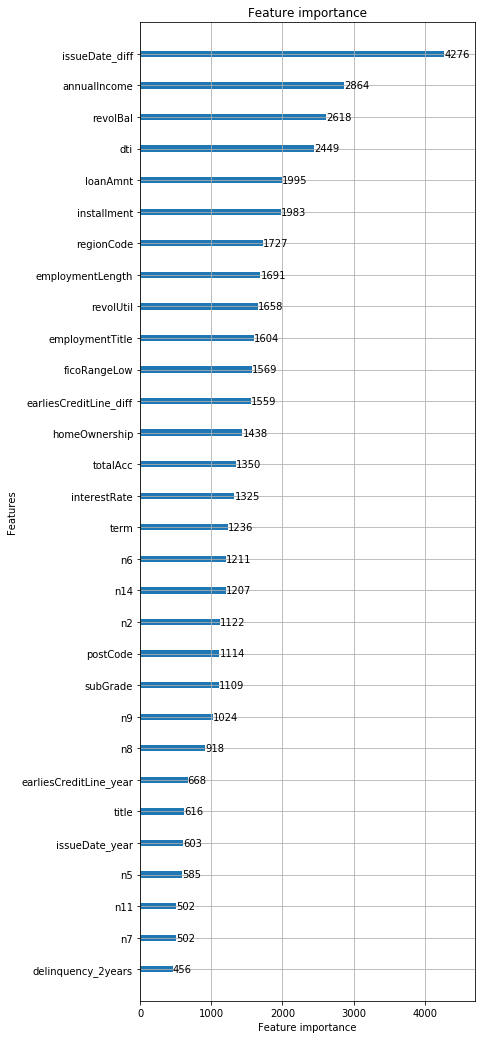

In [ ]:
fig, ax = plt.subplots(figsize=(6,18))
lgb.plot_importance(clf_ex, max_num_features=30, ax = ax)

In [ ]:
pred = clf_ex.predict_proba(X_testA)[:, 1]

In [ ]:
with open('./work/lgbm/clf_ex_参数调优版.pkl', 'wb') as file:
    pickle.dump(clf_ex, file)

In [ ]:
pd.DataFrame(pred).describe(percentiles=[0.25,0.5,0.6,0.7,0.8,0.9,.99])

,0
count,200000.000000
mean,0.251652
std,0.034907
min,0.179927
25%,0.224783
50%,0.253288
60%,0.262463
70%,0.272591
80%,0.284886
90%,0.298462


In [ ]:
# {'id' : testA.index, 'isDefault' : pred}

In [ ]:
submission = pd.DataFrame({'id' : X_testA.index, 'isDefault' : pred})
submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x > 0 else 0)
submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x < 1 else 1)
submission.to_csv('./work/lgbm/submission_lgb_参数调优版.csv', index = None)

## 使用五折交叉验证的LightGBM

In [ ]:
from sklearn.model_selection import StratifiedKFold,KFold
import lightgbm as lgb

In [ ]:
#准备数据
X_train = pd.concat((X_train, X_eval))
y_train = y_train.append(y_eval)

In [ ]:
params_lgb = {
    'objective': 'binary', 'metric':  'binary_logloss,auc',
    'max_depth': 6, 'num_leaves': 50,
    'min_child_samples': 18, 'min_child_weight': 0.001,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9, 'bagging_freq': 2,
    'reg_alpha': 1e-05, 'reg_lambda': 80,
    'cat_smooth': 0
}

In [ ]:
NFOLD = 5

In [ ]:
kf = StratifiedKFold(n_splits = NFOLD, shuffle = True, random_state = 200)
# kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
pred = np.zeros(len(X_testA))

In [ ]:
# ?lgb.train

In [ ]:
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    train_set = lgb.Dataset(X_fold_train, y_fold_train)
    val_set = lgb.Dataset(X_fold_val, y_fold_val, reference=train_set)

    model = lgb.train(params_lgb, train_set, num_boost_round=1000, #early_stopping_rounds=50,
                      valid_sets = val_set, verbose_eval=100)

    pred += model.predict(X_testA, num_iteration=model.best_iteration)/kf.n_splits

# y_pred = [1 if y > 0.5 else 0 for y in y_pred]
# rmse = metrics.accuracy_score(y_pred,y_test)
# print(rmse)

[LightGBM] [Info] Number of positive: 127605, number of negative: 512395
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4060
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199383 -> initscore=-1.390156
[LightGBM] [Info] Start training from score -1.390156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
pd.DataFrame(pred).describe(percentiles=[0.25,0.5,0.6,0.7,0.8,0.9,.99])
# pred[pred > 0.5]

,0
count,200000.000000
mean,0.398802
std,0.023917
min,0.277897
25%,0.383904
50%,0.398033
60%,0.403437
70%,0.409320
80%,0.416616
90%,0.427824


In [ ]:
with open('./work/cv_lgbm/cv_lgbm.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
submission = pd.DataFrame({'id' : X_testA.index, 'isDefault' : pred})
submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x > 0 else 0)
submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x < 1 else 1)
submission.to_csv('./work/cv_lgbm/submission_cvlgb.csv', index = None)

In [ ]:
# train_data_lgb = lgb.Dataset(X_train, y_train, silent=True)

# cv_results = lgb.cv(
#     params_lgb, train_data_lgb, num_boost_round=1000, nfold=5, stratified=False, shuffle=False, 
#     early_stopping_rounds=10, verbose_eval=50, show_stdv=True, seed=2020)

## 使用CatBoost 训练

In [ ]:
# !mkdir /home/aistudio/external-libraries
# !pip install beautifulsoup4 -t /home/aistudio/external-libraries
# !pip install catboost -i https://pypi.tuna.tsinghua.edu.cn/simple -t /home/aistudio/external-libraries

In [12]:
import catboost as cb

### 标记分类变量

In [ ]:
# ?cb.CatBoostClassifier

In [ ]:
cat_model = cb.CatBoostClassifier(iterations=2000, depth=7, learning_rate=0.001, loss_function='Logloss', eval_metric='AUC', metric_period=100)

In [ ]:
# ?cat_model.fit

In [ ]:
cat_model.fit(X_train, y_train, eval_set=(X_eval, y_eval),verbose=True)

0:	test: 0.6953417	best: 0.6953417 (0)	total: 264ms	remaining: 8m 47s
100:	test: 0.7101377	best: 0.7101377 (100)	total: 15.9s	remaining: 4m 59s
200:	test: 0.7107022	best: 0.7107022 (200)	total: 31.7s	remaining: 4m 43s
300:	test: 0.7112396	best: 0.7112396 (300)	total: 48.1s	remaining: 4m 31s
400:	test: 0.7118122	best: 0.7118122 (400)	total: 1m 4s	remaining: 4m 17s
500:	test: 0.7123503	best: 0.7123503 (500)	total: 1m 20s	remaining: 4m
600:	test: 0.7129757	best: 0.7129757 (600)	total: 1m 36s	remaining: 3m 44s
700:	test: 0.7135453	best: 0.7135453 (700)	total: 1m 52s	remaining: 3m 29s
800:	test: 0.7141596	best: 0.7141596 (800)	total: 2m 8s	remaining: 3m 12s
900:	test: 0.7147863	best: 0.7147863 (900)	total: 2m 24s	remaining: 2m 56s
1000:	test: 0.7153816	best: 0.7153816 (1000)	total: 2m 40s	remaining: 2m 40s
1100:	test: 0.7159762	best: 0.7159762 (1100)	total: 2m 56s	remaining: 2m 23s
1200:	test: 0.7165293	best: 0.7165293 (1200)	total: 3m 13s	remaining: 2m 8s
1300:	test: 0.7171058	best: 0.7171

In [ ]:
y_pred = cat_model.predict(X_eval)
print(accuracy_score(y_eval, y_pred))

0.80331875


In [ ]:
roc_auc_score(y_eval, y_pred)

0.5139742945401401

In [ ]:
cat_model.get_feature_importance()

array([9.29844384e-01, 1.35444392e+01, 1.30410763e+01, 8.15818310e-01,
       1.54091412e+01, 2.28591942e+01, 2.97123438e-01, 1.17086455e+00,
       6.87194450e+00, 2.47041691e+00, 5.03326017e-01, 9.52872725e-03,
       1.37649297e-02, 1.05959176e-02, 4.15134737e+00, 9.59488281e-03,
       2.53836146e+00, 2.71321455e+00, 1.38579051e-02, 6.08530621e-03,
       6.81123289e-03, 2.74251200e-01, 7.69585810e-02, 3.73667760e-02,
       1.19066814e-02, 4.96410988e-03, 2.65061640e-01, 0.00000000e+00,
       4.66142957e-03, 5.61442838e-02, 5.54689815e-01, 7.25162367e-01,
       2.86460655e-02, 1.18928289e-02, 1.83732386e-02, 3.66414746e-02,
       1.34146004e-02, 4.68281187e-01, 1.82287849e-02, 1.55109376e-01,
       1.18609767e-02, 9.63022463e-03, 3.69784642e-01, 3.56794433e+00,
       1.24512162e-02, 5.75988062e+00, 2.43602383e-02, 7.22258274e-03,
       8.87594906e-02])

In [ ]:
pred = cat_model.predict_proba(X_testA)[:,1]

In [ ]:
pd.DataFrame(pred).describe(percentiles=[0.25,0.5,0.6,0.7,0.8,0.9,.99])

,0
count,200000.000000
mean,0.225393
std,0.103802
min,0.049007
25%,0.141100
50%,0.207666
60%,0.237213
70%,0.270913
80%,0.313829
90%,0.376757


In [ ]:
with open('./work/catboost/cat_model.pkl', 'wb') as file:
    pickle.dump(cat_model, file)

In [ ]:
submission = pd.DataFrame({'id' : X_testA.index, 'isDefault' : pred})
submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x > 0 else 0)
submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x < 1 else 1)
submission.to_csv('./work/catboost/submission_cb.csv', index = None)

## 使用五折交叉验证的CatBoost

In [13]:
from sklearn.model_selection import StratifiedKFold,KFold
import catboost as cb

In [14]:
data_X = X_train.copy()
data_y = y_train.copy()
data_X_eval = X_eval.copy()
data_X_testA = X_testA.copy()

### 标记分类变量

In [15]:
# train.columns
categorical_fea

['verificationStatus',
 'policyCode',
 'applicationType',
 'title',
 'initialListStatus',
 'postCode',
 'regionCode',
 'employmentTitle',
 'purpose',
 'homeOwnership']

In [16]:
for i in data_X.columns:
    if i in categorical_fea:
        data_X[i] = data_X[i].astype('str')

In [17]:
for i in data_X_eval.columns:
    if i in categorical_fea:
        data_X_eval[i] = data_X_eval[i].astype('str')

In [18]:
for i in data_X_testA.columns:
    if i in categorical_fea:
        data_X_testA[i] = data_X_testA[i].astype('str')

In [19]:
# data_X[data_y['isDefault']== 1]

In [ ]:
# ?pd.DataFrame

In [19]:
#尝试增加isDefault=1的样本数量
data_X = pd.concat((data_X, data_X[data_y['isDefault']== 1], data_X[data_y['isDefault']== 1]))

data_y = pd.concat((data_y, pd.DataFrame(np.ones(data_y[data_y['isDefault']== 1].shape[0] * 2), columns = ['isDefault']).astype('int')))

In [20]:
cv_cat_model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', 
                                  iterations=500, depth=7, learning_rate=0.1, 
                                  random_state=2020, od_type="Iter",
                                  bagging_temperature=0.5, sampling_frequency='PerTree', sampling_unit='Object',
                                  colsample_bylevel=0.8,
                                  metric_period=100)

In [21]:
clfs = []
answers = []
answers_eval = []
mean_score = 0
NFOLD = 5

In [22]:
kf = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=2019)

In [23]:
for fold, (train_index, val_index) in enumerate(kf.split(data_X, data_y)):
    X_fold_train, X_fold_val = data_X.iloc[train_index], data_X.iloc[val_index]
    y_fold_train, y_fold_val = data_y.iloc[train_index], data_y.iloc[val_index]
    print("fold:", fold)
    clf = cv_cat_model.fit(X_fold_train, y_fold_train, eval_set=(X_fold_val, y_fold_val),
                           verbose=True, cat_features=categorical_fea)
    clfs.append(clf)

    pred_fold_val = clfs[fold].predict(X_fold_val, prediction_type='Probability')[:,-1]
    # print('pred_fold_val:',pred_fold_val)
    print('cat验证的auc:{}'.format(roc_auc_score(y_fold_val, pred_fold_val)))
    mean_score += roc_auc_score(y_fold_val, pred_fold_val) / NFOLD

    pred = clfs[fold].predict(data_X_testA, prediction_type='Probability')[:,-1]
    answers.append(pred)

    pred_eval = clfs[fold].predict(data_X_eval, prediction_type='Probability')[:,-1]
    answers_eval.append(pred_eval)

fold: 0


0:	test: 0.6971059	best: 0.6971059 (0)	total: 1.26s	remaining: 10m 29s
100:	test: 0.9868819	best: 0.9868819 (100)	total: 2m 3s	remaining: 8m 7s
200:	test: 0.9876863	best: 0.9876863 (200)	total: 4m 5s	remaining: 6m 5s
300:	test: 0.9880280	best: 0.9880293 (296)	total: 6m 4s	remaining: 4m
400:	test: 0.9883329	best: 0.9883371 (383)	total: 8m 1s	remaining: 1m 58s
499:	test: 0.9884519	best: 0.9884561 (494)	total: 9m 57s	remaining: 0us

bestTest = 0.9884561139
bestIteration = 494

Shrink model to first 495 iterations.
cat验证的auc:0.9884561138627751
fold: 1


0:	test: 0.7011966	best: 0.7011966 (0)	total: 1.05s	remaining: 8m 44s
100:	test: 0.9862103	best: 0.9862103 (100)	total: 2m	remaining: 7m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9863460776
bestIteration = 130

Shrink model to first 131 iterations.
cat验证的auc:0.9863460775990877
fold: 2


0:	test: 0.7017652	best: 0.7017652 (0)	total: 996ms	remaining: 8m 16s
100:	test: 0.9862145	best: 0.9862152 (99)	total: 2m 2s	remaining: 8m 5s
200:	test: 0.9870128	best: 0.9870128 (200)	total: 4m 2s	remaining: 6m
300:	test: 0.9874707	best: 0.9874795 (292)	total: 6m	remaining: 3m 58s
400:	test: 0.9876298	best: 0.9876298 (400)	total: 7m 59s	remaining: 1m 58s
499:	test: 0.9878354	best: 0.9878362 (498)	total: 9m 52s	remaining: 0us

bestTest = 0.9878361691
bestIteration = 498

Shrink model to first 499 iterations.
cat验证的auc:0.9878361691163197
fold: 3


0:	test: 0.7020554	best: 0.7020554 (0)	total: 979ms	remaining: 8m 8s
100:	test: 0.9861101	best: 0.9861209 (94)	total: 2m 2s	remaining: 8m 2s
200:	test: 0.9866262	best: 0.9866329 (198)	total: 3m 55s	remaining: 5m 50s
300:	test: 0.9869858	best: 0.9869858 (300)	total: 5m 49s	remaining: 3m 50s
400:	test: 0.9871808	best: 0.9871808 (400)	total: 7m 44s	remaining: 1m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9872104644
bestIteration = 429

Shrink model to first 430 iterations.
cat验证的auc:0.9872104643645006
fold: 4


0:	test: 0.6997155	best: 0.6997155 (0)	total: 1.01s	remaining: 8m 25s
100:	test: 0.9864416	best: 0.9864416 (100)	total: 2m 1s	remaining: 7m 58s
200:	test: 0.9872309	best: 0.9872309 (200)	total: 3m 59s	remaining: 5m 55s
300:	test: 0.9874609	best: 0.9874624 (299)	total: 5m 55s	remaining: 3m 55s
400:	test: 0.9878224	best: 0.9878224 (400)	total: 7m 53s	remaining: 1m 56s
499:	test: 0.9882307	best: 0.9882307 (499)	total: 9m 51s	remaining: 0us

bestTest = 0.9882306587
bestIteration = 499

cat验证的auc:0.9882306586508337


In [24]:
print('mean valAuc:{}'.format(mean_score))

mean valAuc:0.9876158967187034


In [25]:
print(accuracy_score(y_eval, (sum(answers_eval)/NFOLD > 0.5)))

0.796625


In [26]:
roc_auc_score(y_eval, sum(answers_eval)/NFOLD)

0.7248095193902123

In [27]:
#最终加权平均的预测结果
cat_pre=sum(answers)/NFOLD

In [ ]:
with open('./work/cv_catboost/cv_catboost.pkl', 'wb') as file:
    pickle.dump(ck_cat_model, file)

In [28]:
submission = pd.DataFrame({'id' : X_testA.index, 'isDefault' : cat_pre})
# submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x > 0 else 0)
# submission['isDefault'] = submission['isDefault'].apply(lambda x : x if x < 1 else 1)
submission.to_csv('./work/cv_catboost/submission_cv_catboost220211210_4.csv', index = None)

In [ ]:
#检查重要特征
pd.DataFrame({'feature_names_' :clfs[1].feature_names_, 'feature_importances_': clfs[1].feature_importances_}).sort_values(by='feature_importances_', ascending=False)

# clfs[0].get_best_score(), clfs[2].get_best_score(), clfs[3].get_best_score()

,feature_names_,feature_importances_
5,subGrade,12.635970
45,issueDate_diff,7.985715
2,interestRate,7.704567
1,term,6.333897
6,employmentTitle,5.233110
8,homeOwnership,4.090816
21,revolBal,4.086887
14,dti,4.005348
9,annualIncome,3.886682
4,grade,3.727884
